# Basic analysis methods within the `spatialdata` ecosystem 

In this notebook, we will explore how to use `spatialdata-plot` to generate static plots of various different technologies. When we load the `spatialdata-plot` library, this adds the `.pl` accessor to every `SpatialData` object, which gives us access to the plotting functions. Their logic is loosly inspired by the ggplot-library in R, in which one can chain multiple function calls, gradually building the final figure.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import spatialdata as sd
import spatialdata_plot as sdp
import matplotlib.pyplot as plt  # for multi-panel plots later
import scanpy as sc
import squidpy as sq
import pandas as pd

for p in [sd, sdp, sc, sq]:
    print(f"{p.__name__}: {p.__version__}")

sdata_xenium = sd.read_zarr("../data/xenium.zarr")
sdata_xenium

spatialdata: 0.2.2
spatialdata_plot: 0.2.6.dev2+g1bd4b78
scanpy: 1.10.2
squidpy: 1.2.2


/Users/tim.treis/anaconda3/envs/spatialdata-workshop/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


SpatialData object, with associated Zarr store: /Users/tim.treis/Documents/GitHub/spatialdata-workshops/data/xenium.zarr
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 5636, 1448), (3, 2818, 724), (3, 1409, 362), (3, 704, 181), (3, 352, 90)
│     └── 'morphology_focus': DataTree[cyx] (1, 17098, 51187), (1, 8549, 25593), (1, 4274, 12796), (1, 2137, 6398), (1, 1068, 3199)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
│     └── 'nucleus_labels': DataTree[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (162254, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (162254, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (156628, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (162254, 377)
with coordinate sys

## Subset the Xenium data for the scope of this workshop 

Data has 12165021 transcript locations.
INFO     Rasterizing image for faster rendering.                                                                   


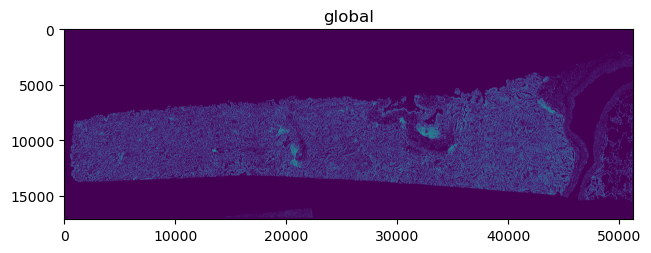

In [3]:
print(f"Data has {sdata_xenium.points['transcripts'].compute().shape[0]} transcript locations.")
sdata_xenium.pl.render_images("morphology_focus").pl.show()

Crop has 2683201 transcript locations.


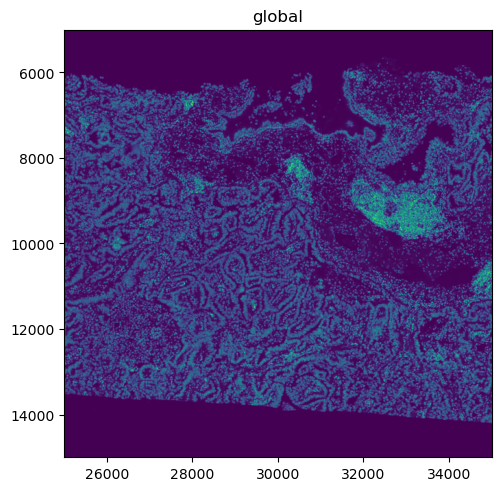

In [4]:
sdata_crop = sdata_xenium.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[25000, 5000],
    max_coordinate=[35000, 15000],
    target_coordinate_system="global",
)
print(
    f"Crop has {sdata_crop.points['transcripts'].compute().shape[0]} transcript locations."
)
sdata_crop.pl.render_images("morphology_focus").pl.show()

In [5]:
sdata_crop.tables["table"]

AnnData object with n_obs × n_vars = 33727 × 377
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

In [6]:
sc.pp.normalize_total(sdata_crop.tables["table"], inplace=True)
sc.pp.log1p(sdata_crop.tables["table"])
sc.pp.pca(sdata_crop.tables["table"])
sc.pp.neighbors(sdata_crop.tables["table"])
sc.tl.umap(sdata_crop.tables["table"])
sc.tl.leiden(sdata_crop.tables["table"])

/Users/tim.treis/anaconda3/envs/spatialdata-workshop/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/var/folders/qg/qgc908995g3fc8qtss2fsbhhxyxxj4/T/ipykernel_52340/3929988892.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(sdata_crop.tables["table"])


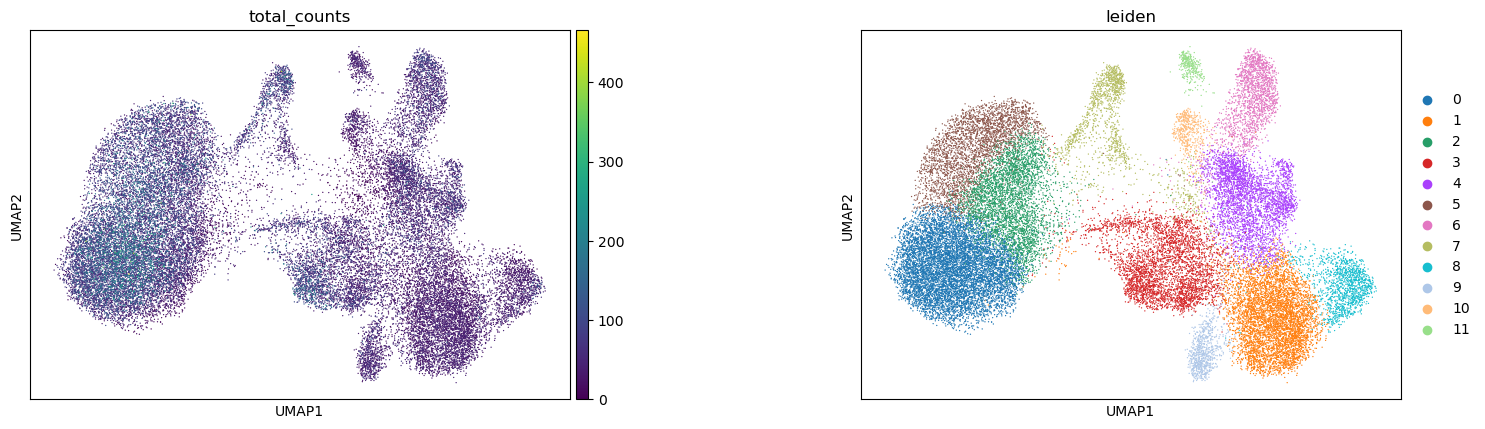

In [7]:
sc.pl.umap(
    sdata_crop.tables["table"],
    color=[
        "total_counts",
        "leiden",
    ],
    wspace=0.4,
)

### Rename clusters

/Users/tim.treis/Documents/GitHub/spatialdata-plot/src/spatialdata_plot/pl/utils.py:786: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


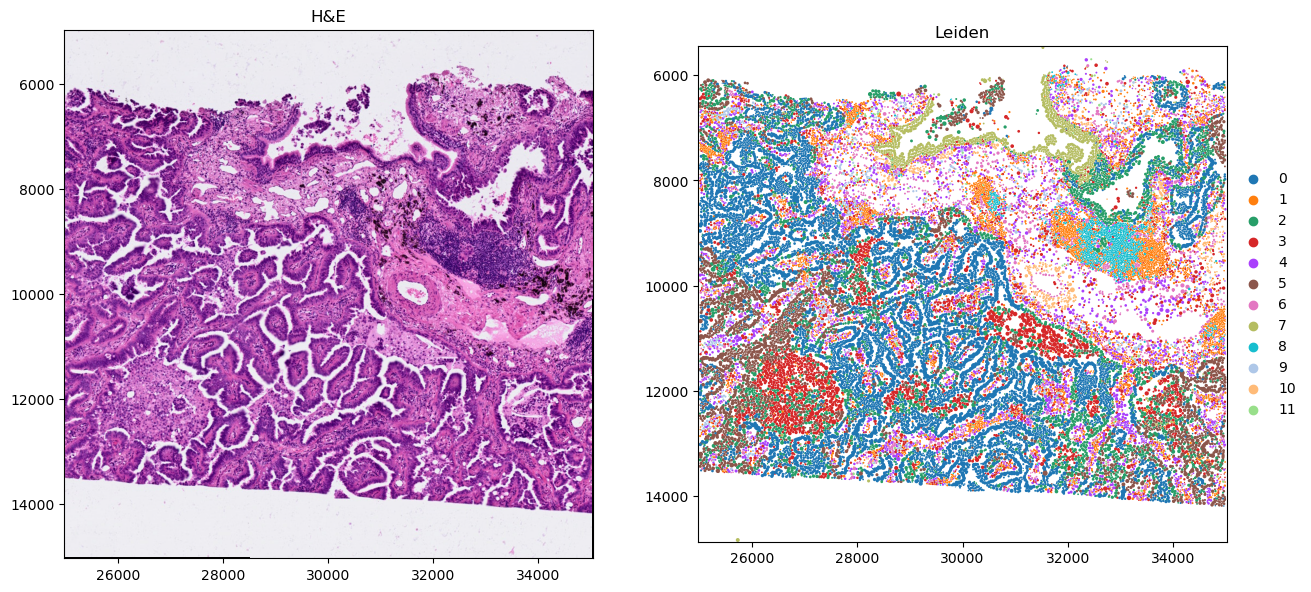

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

sdata_crop.pl.render_images("he_image").pl.show(ax=axs[0], title="H&E")

sdata_crop.pl.render_shapes(
    "cell_circles",
    color="leiden",
    method="matplotlib",
).pl.show(ax=axs[1], title="Leiden")

## Modify the groups based on the Leiden UMAP

In [12]:
for i in [2, 5]:
    sdata_crop.tables["table"].obs["leiden"].replace(f"{i}", "0", inplace=True)

for i in [1, 4, 6, 8, 10, 11]:
    sdata_crop.tables["table"].obs["leiden"].replace(f"{i}", "9", inplace=True)

/var/folders/qg/qgc908995g3fc8qtss2fsbhhxyxxj4/T/ipykernel_52340/2302851329.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sdata_crop.tables["table"].obs["leiden"].replace(f"{i}", "0", inplace=True)
/var/folders/qg/qgc908995g3fc8qtss2fsbhhxyxxj4/T/ipykernel_52340/2302851329.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which

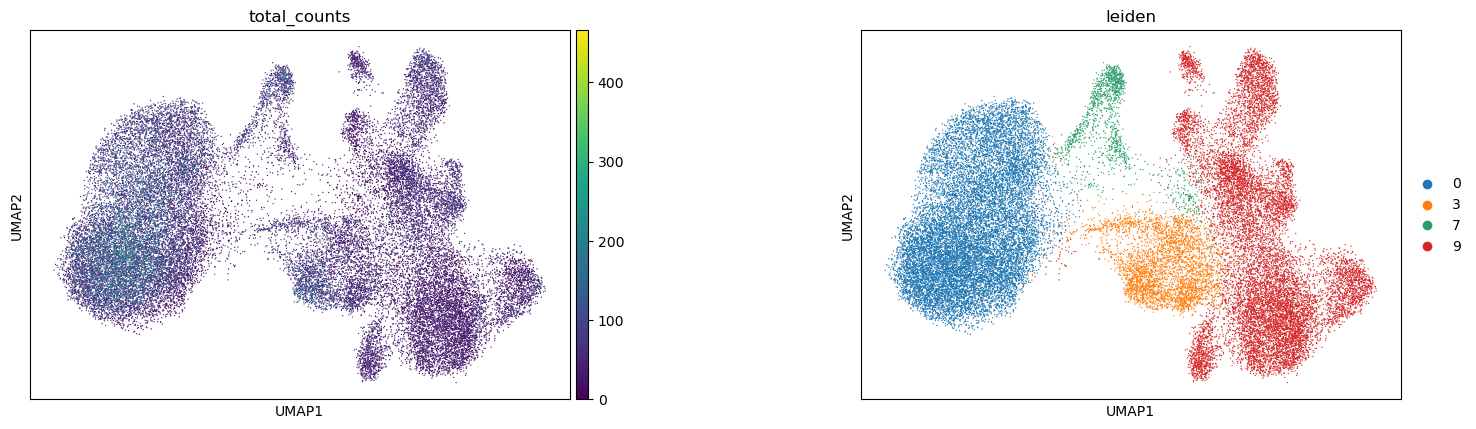

In [13]:
sc.pl.umap(
    sdata_crop.tables["table"],
    color=[
        "total_counts",
        "leiden",
    ],
    wspace=0.4,
)

/Users/tim.treis/Documents/GitHub/spatialdata-plot/src/spatialdata_plot/pl/utils.py:786: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


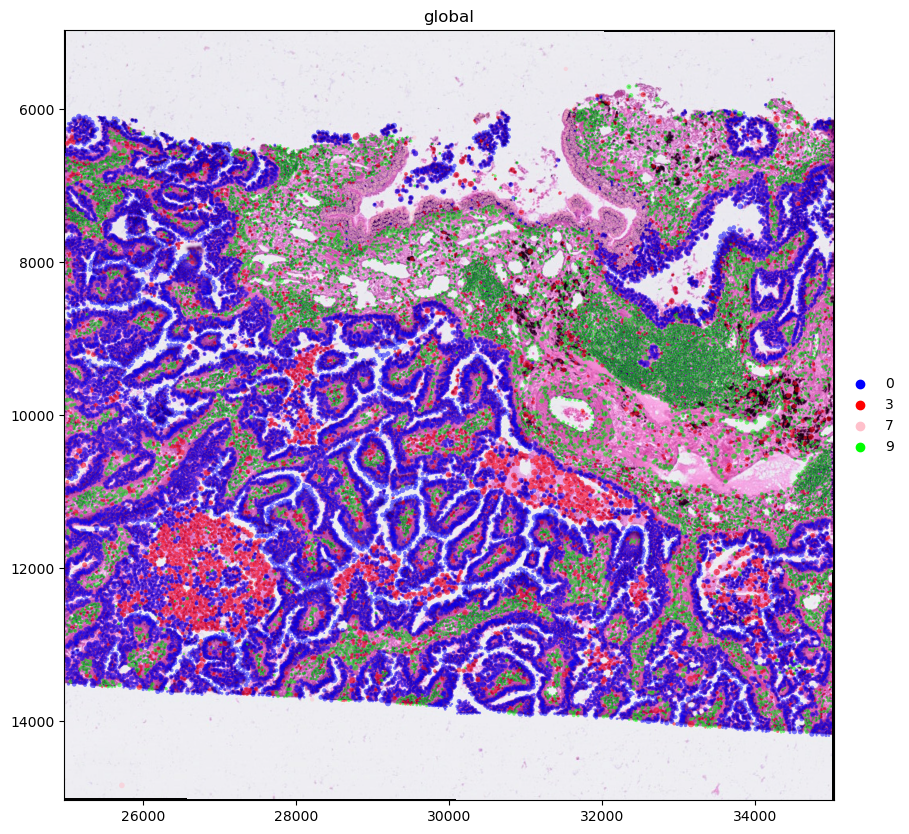

In [14]:
sdata_cropfig, ax = plt.subplots(1, 1, figsize=(10, 10))

sdata_crop.pl.render_images("he_image").pl.render_shapes(
    "cell_circles",
    color="leiden",
    fill_alpha=0.5,
    palette=["blue", "red", "pink", "lime"],
    groups=["0", "3", "7", "9"],
    method="matplotlib",
).pl.show(ax=ax)